# Test of doubly tapered Mestel disk simulation with EXP

$$
\Psi_o(R) = V_o^2 \log\frac{R}{R_o} \qquad \Sigma(R) = \frac{V_o^2}{2\pi G R} T_{inner}(R) T_{outer}(R)
$$
where
$$
T_{inner}(R) = \frac{R^\nu}{R_i^\nu | R^\nu}
$$
and
$$
T_{outer}(R) = \frac{R_o^\mu}{R_o^\mu+R^\mu}
$$

### pyEXP setup

In [1]:
import os
import copy
import yaml
import time
import pyEXP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
from os.path import exists

plt.rcParams['figure.figsize'] = [12, 9]

# Change to the example's working directory
os.chdir('Zang')
print(os.getcwd())

/home/weinberg/Projects/pyEXP-examples/Tutorials/EXP/Zang


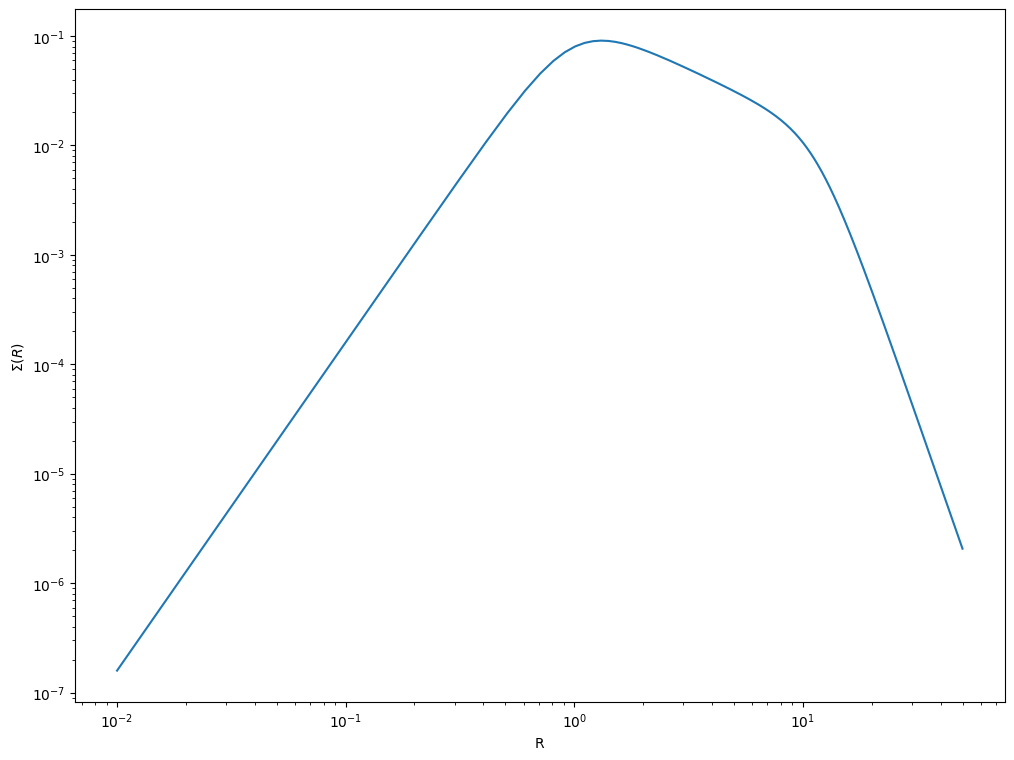

In [2]:
Ri = 1.0
Ro = 11.5
Vo = 1.0
Nu = 4.0
Mu = 5.0
Rmin = 0.01
Rmax = 50.0

def Tinner(R, nu):
    return np.power(R, nu)/(np.power(R, nu) + np.power(Ri, nu))

def Touter(R, mu):
    return np.power(Ro, mu)/(np.power(R, mu) + np.power(Ro, mu))

def Sigma(R, nu, mu):
    return Vo**2/(2*np.pi*R)*Tinner(R, nu)*Touter(R, mu)

R = np.arange(Rmin, Rmax, 0.1)
D = Sigma(R, Nu, Mu)
plt.loglog(R, D)
plt.xlabel('R')
plt.ylabel('$\Sigma(R)$')
plt.savefig('density.png')
plt.show()

## Make initial conditions

Initial conditions can be made with the `zangics` utility.  The options are:

In [3]:
! zangics -h

Ideal tapered Mestel IC generator
Usage:
  zangics [OPTION...]

  -h, --help        Print this help message
  -V, --nozerovel   Do not zero the mean velocity
  -P, --nozeropos   Do not zero the center of mass
  -d, --debug       Print debug grid
  -N, --number arg  Number of particles to generate (default: 100000)
  -n, --nu arg      Inner taper exponent (0 for no taper) (default: 2.0)
  -m, --mu arg      Outer taper exponent (0 for no taper) (default: 2.0)
  -i, --Ri arg      Inner radius for taper (default: 1.0)
  -o, --Ro arg      Outer radius for taper (default: 20.0)
  -r, --Rmin arg    Inner radius for model (default: 0.001)
  -R, --Rmax arg    Outer radius for model (default: 50.0)
  -S, --sigma arg   Radial velocity dispersion (default: 1.0)
  -s, --seed arg    Random number seed. Default: use /dev/random
  -f, --file arg    Output body file (default: zang.bods)




Let's make a set of initial conditions for the disk illustrated above.

In [4]:
N = 100000
S = 0.325
os.system('zangics --number {} --nu {} --mu {} --Rmin {} --Rmax {} --sigma {}'.format(N, Nu, Mu, Rmin, Rmax, S))


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

** Main loop complete
** Position center: 0.0151408, -0.0137128, 0
** Velocity center: 0.000144067, -7.29505e-05, 0
** 0 particles failed acceptance
** Particle mass=0.000201561
** 2T/VC=0.999776


0

### Running the simulation

We have provided a sample `exp` configuration file in this working directory.  The default name for a configuration file is
`config.yml`.    

The basis build can take minutes.  If you want to experiment with the disk parameters, be prepared to wait a few minutes while 
the basis rebuilds.  The entire run will take under an hour; and under 10 minutes on a modern laptop.  So be prepared to 
take a short break. 

The `exp` code will run for 1000 steps.  You can estimate the total run time by looking at the last line of every step diagnostic 
stanza that estimates the time needed for each part of the caluculation.  The 'Total' field is the total run time in seconds per step.  E.g. if your computer is requiring 0.3 seconds per step, the completion time will be 10 minutes.

In [5]:
%%time
! mpirun -np 8 --oversubscribe exp

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#   Node name           PID         Executable                              
-   ---------           ---         ----------                              
0   9d95843ecf7d        6955        exp                                     
1   9d95843ecf7d        6956        exp                                     
2   9d95843ecf7d        6957        exp                                     
3   9d95843ecf7d        6958        exp                                     
4   9d95843ecf7d        6959        exp                                     
5   9d95843ecf7d        6960        exp                                     
6   9d95843ecf7d        6961        exp                                     
7   9d95843ecf7d        6962        exp                                     
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

### Configure the basis and read coefficients

In [6]:
# Get the basis config
#
stream = open('config.yml', 'r')
config = yaml.full_load(stream)
# del config['Components'][0]['force']['parameters']['NO_MONO']
disk_config = yaml.dump(config['Components'][0]['force'])
# print(disk_config)

# Get the coefficient file
for v in config['Output']:
    if v['id'] == 'outcoef':
        coeffile = v['parameters']['filename']
        
# Move to the data directory
os.chdir('data')

# Construct the basis instance
#
disk_basis = pyEXP.basis.Basis.factory(disk_config)

---- EmpCyl2d::ModelCyl: Making a double-tapered Zang with Mouter: 5.0
Ninner: 4.0
Ri: 1.0
Ro: 11.5
vrot: 1.0
---- EmpCyl2d::Basis2d: Making a finite Bessel basis
---- EmpCyl2d::ReadH5Cache: read 2d basis cache <.eof_cache_2d>
FlatDisk::orthoTest: worst=2.23983e-06


---- BiorthCyl::ReadH5Cache: read <./eof_cache_2d.50>


### Read the coefficients
This is a HDF5 file previously computed using the `make_coefficients_MPI.py` script.  You simply need to point `coeffile` at some coefficient file.   In this notebook, we will make a copy of the originaly coefficient set 'coefs0' to get a working copy 'coefs' that will be used for MSSA updates.

In [7]:
coeffile1 = 'outcoef.disk.run0'
coefs0 = pyEXP.coefs.Coefs.factory(coeffile1, 10)
coefs  = coefs0.deepcopy()

## Plot the gravitational power

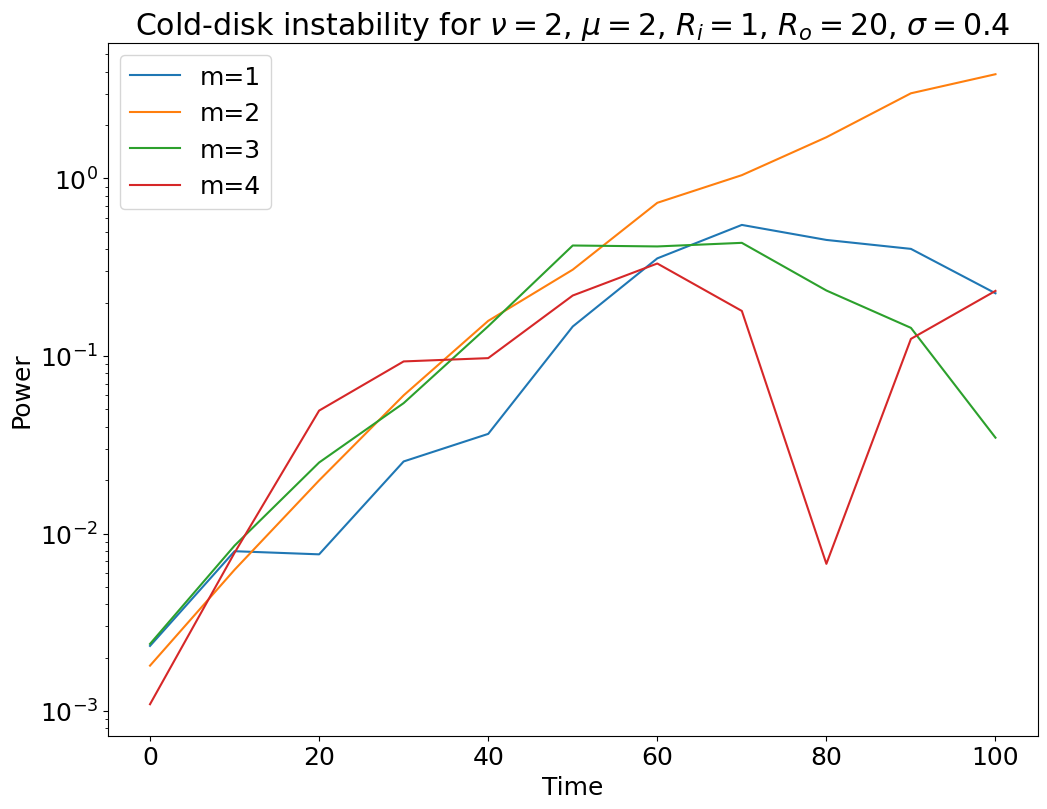

In [8]:
pow = coefs.Power()
plt.rcParams.update({'font.size': 18})
plt.semilogy(coefs.Times(), pow[:,1], label='m=1')
plt.semilogy(coefs.Times(), pow[:,2], label='m=2')
plt.semilogy(coefs.Times(), pow[:,3], label='m=3')
plt.semilogy(coefs.Times(), pow[:,4], label='m=4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Power')
plt.title(r'Cold-disk instability for $\nu=2$, $\mu=2$, $R_i=1$, $R_o=20$, $\sigma=0.4$')
plt.show()

plt.plot(coefs.Times(), pow[:,1], label='m=1')
plt.plot(coefs.Times(), pow[:,2], label='m=2')
plt.plot(coefs.Times(), pow[:,3], label='m=3')
plt.plot(coefs.Times(), pow[:,4], label='m=4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Power')
plt.title(r'Cold-disk instability for $\nu=2$, $\mu=2$, $R_i=1$, $R_o=20$, $\sigma=0.4$')
plt.show()

In [9]:
# Restricting subspace

for T in coefs.Times():
    data = coefs(T)
    for i in range(data.shape[0]):
        if i!=2:
            for j in range(data.shape[1]): 
                data[i, j] = 0.0
    coefs.setMatrix(T, data)

## Plot some density slices

In [10]:
times = coefs.Times()
rmax  = 20
ngrd  = 100
pmin  = [ -rmax, -rmax, 0.0]
pmax  = [  rmax,  rmax, 0.0]
grid  = [  ngrd,  ngrd,   0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

print('Created fields instance')

surfaces = fields.slices(disk_basis, coefs)

Created fields instance


### Get density min and max for level surface scaling

In [11]:
dmin =  1e20
dmax = -1e20
for time in coefs.Times():
    dmin = min(dmin, np.min(surfaces[time]['dens']))
    dmax = max(dmax, np.max(surfaces[time]['dens']))
print(dmin, dmax)

-0.020034991 0.020034991


In [12]:
# Get the shape
keys = list(surfaces.keys())
nx = surfaces[keys[0]]['dens'].shape[0]
ny = surfaces[keys[0]]['dens'].shape[1]

# Make the mesh
x = np.linspace(-rmax, rmax, nx)
y = np.linspace(-rmax, rmax, ny)
xv, yv = np.meshgrid(x, y)

plt.rcParams.update({'font.size': 22})

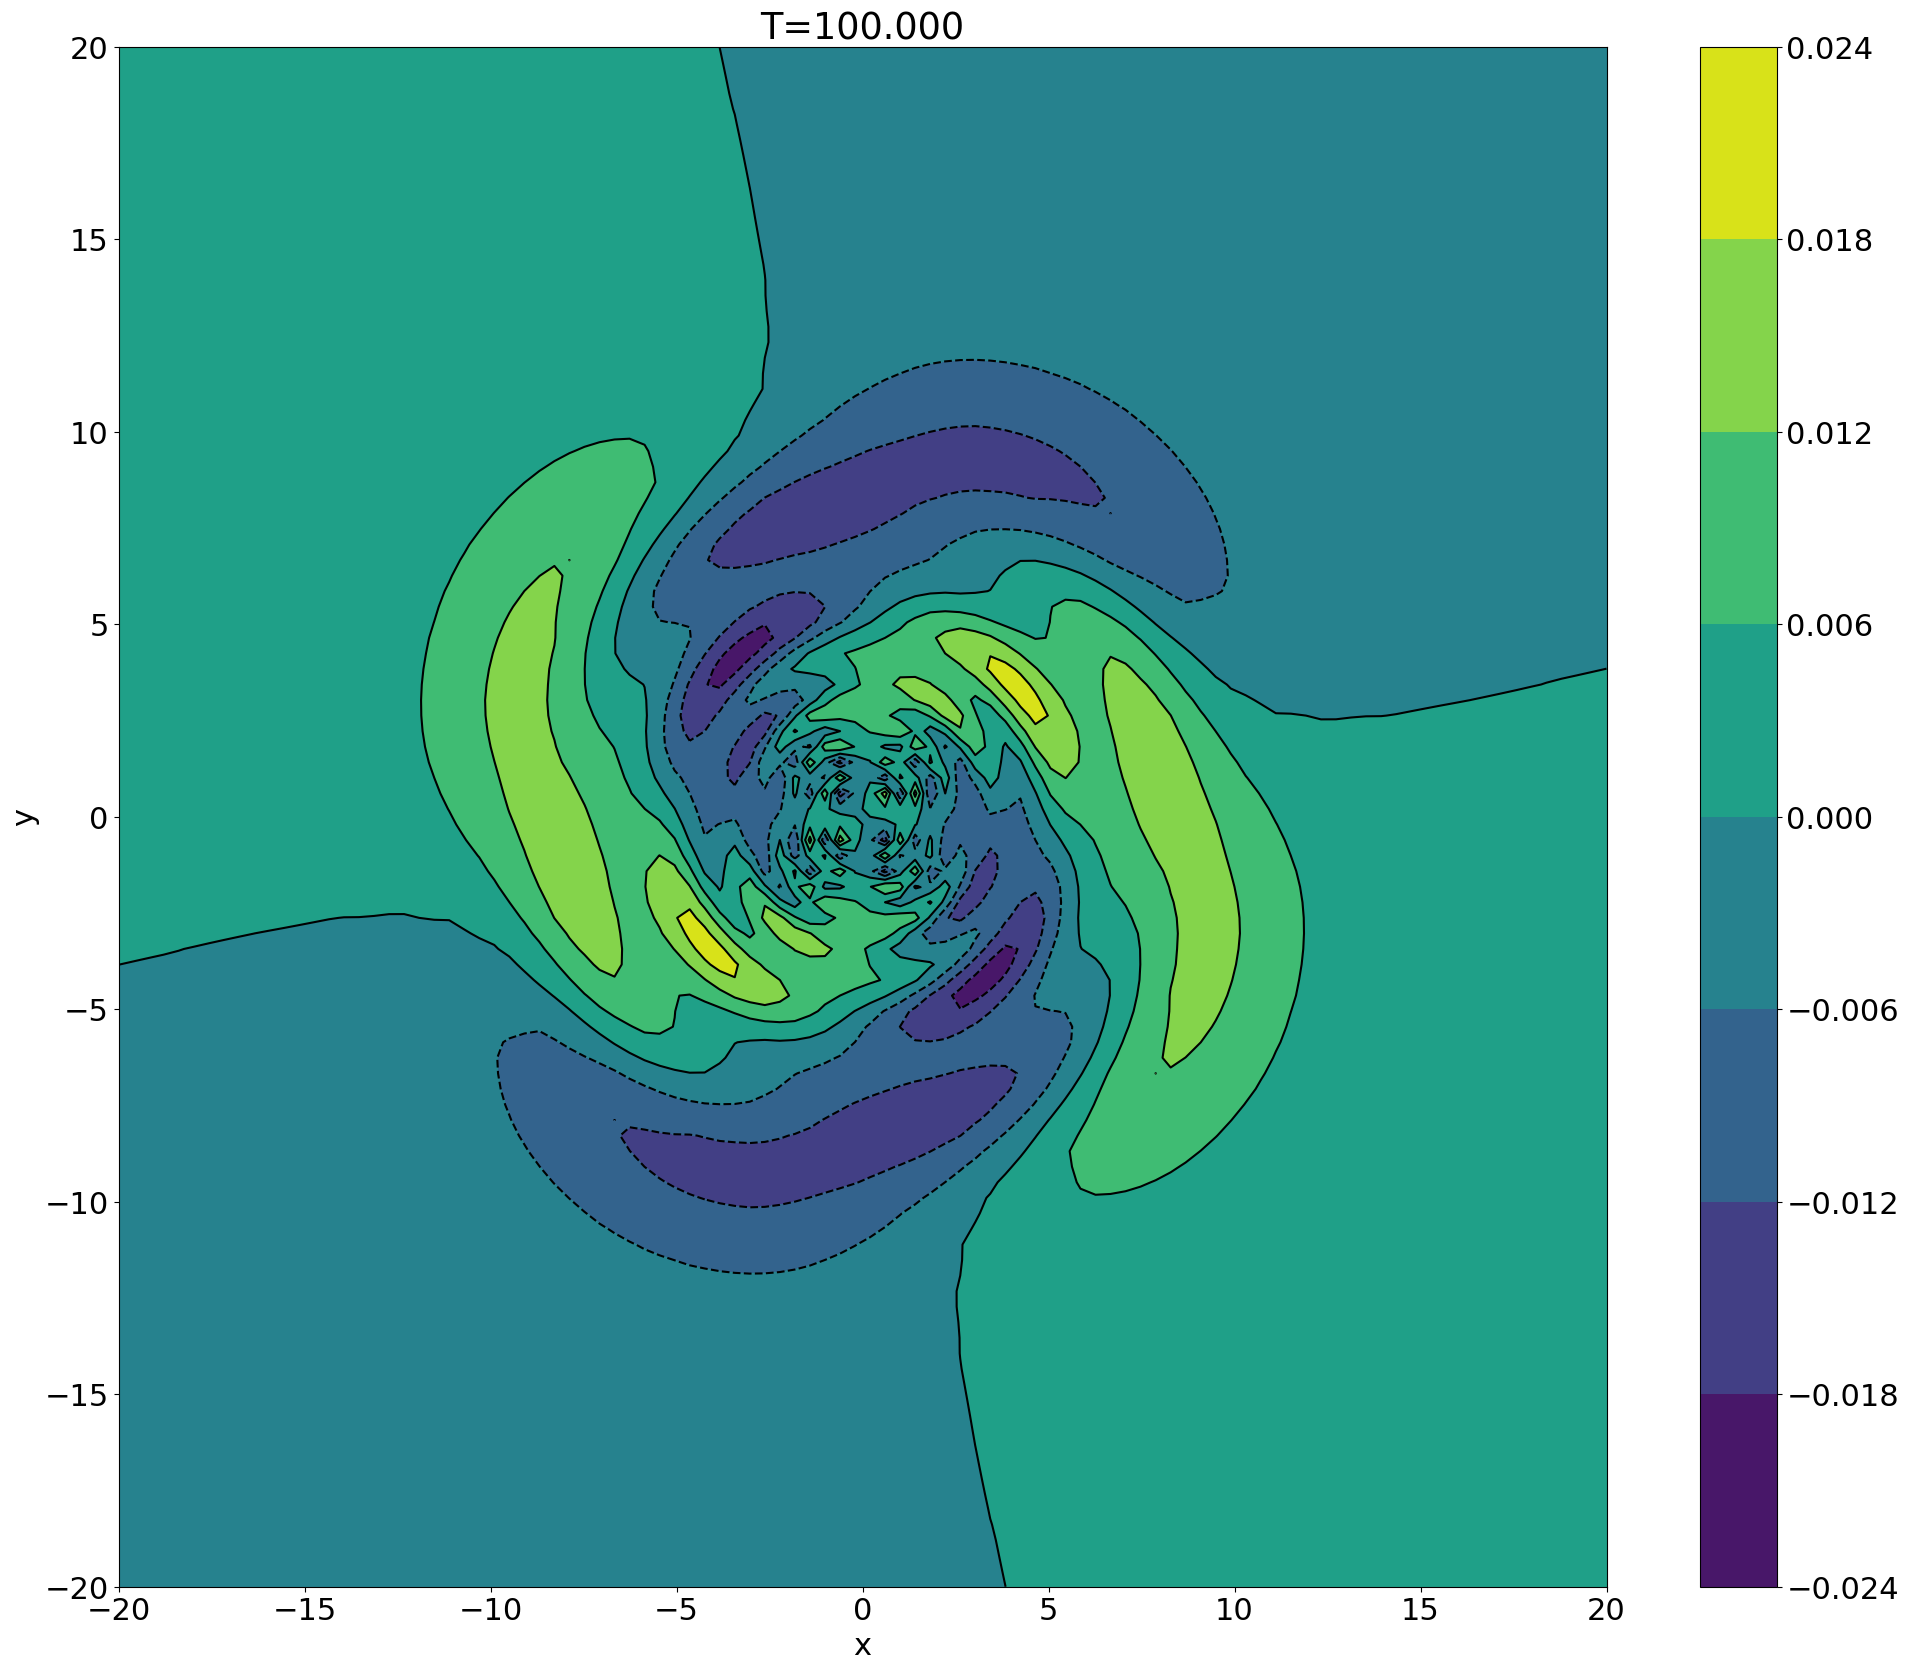

In [13]:
for index in range(0, len(keys), 10):
    fig, ax = plt.subplots(1, 1, figsize=(24, 20))
    key = keys[index]
    mat = surfaces[key]['dens']

    cont1 = ax.contour(xv, yv, mat.transpose(), colors='k')
    cont2 = ax.contourf(xv, yv, mat.transpose())
    plt.colorbar(cont2, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('T={:4.3f}'.format(key))
    plt.show()

## Orthogonality check

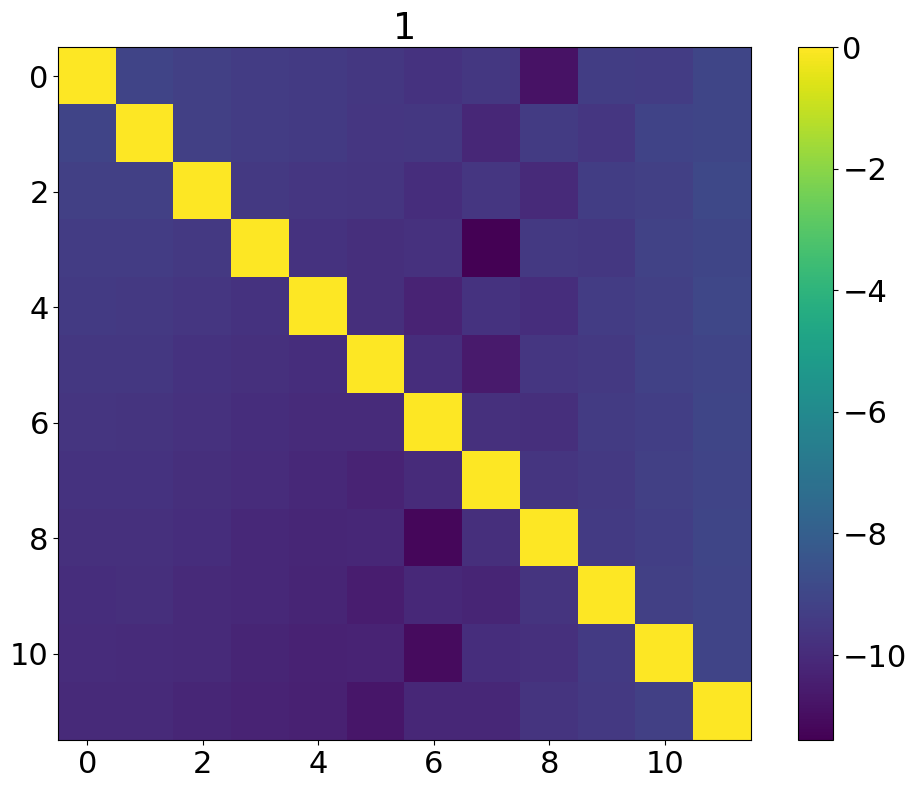

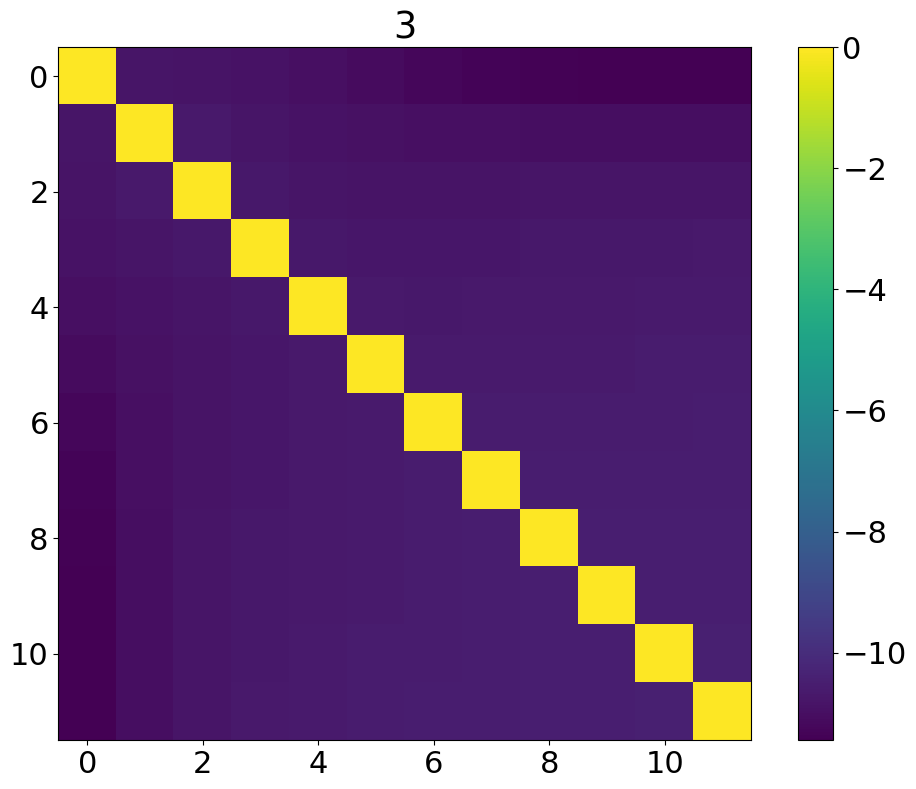

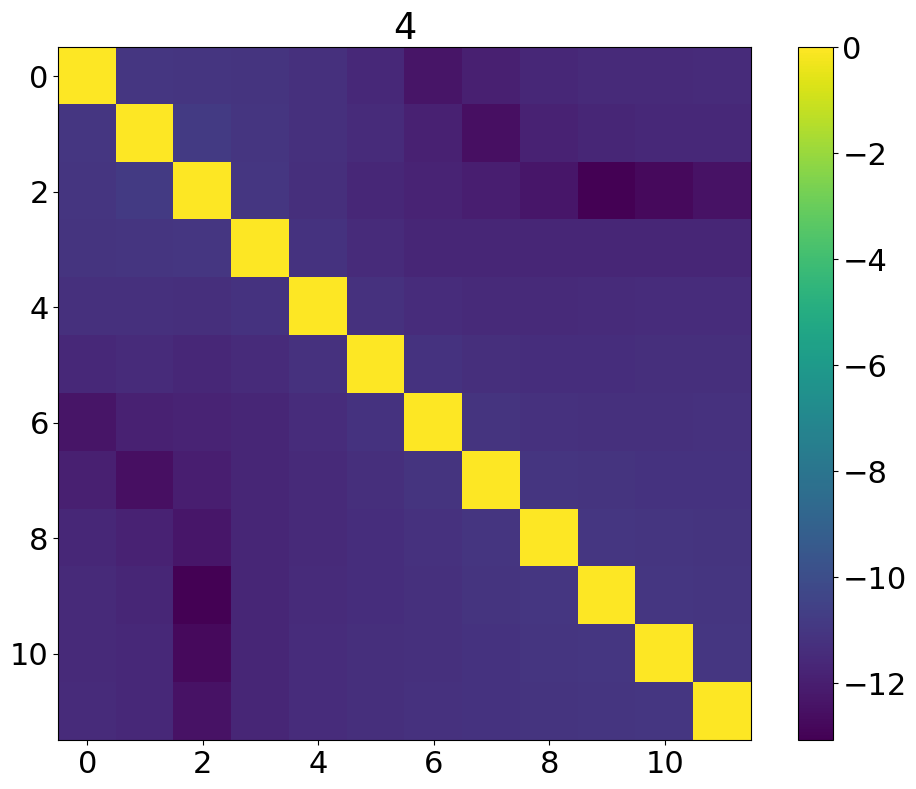

In [14]:
ret = disk_basis.orthoCheck()
ctr = 0
for v in ret: 
    g = plt.imshow(np.log10(np.abs(v)))
    plt.colorbar(g)
    plt.title(str(ctr))
    plt.plot()
    plt.show()
    ctr += 1

## Look at some basis functions

In [15]:
logxmin = -1
logxmax =  2
numgrid = 2000

disk_grid = disk_basis.getBasis(logxmin, logxmax, numgrid)

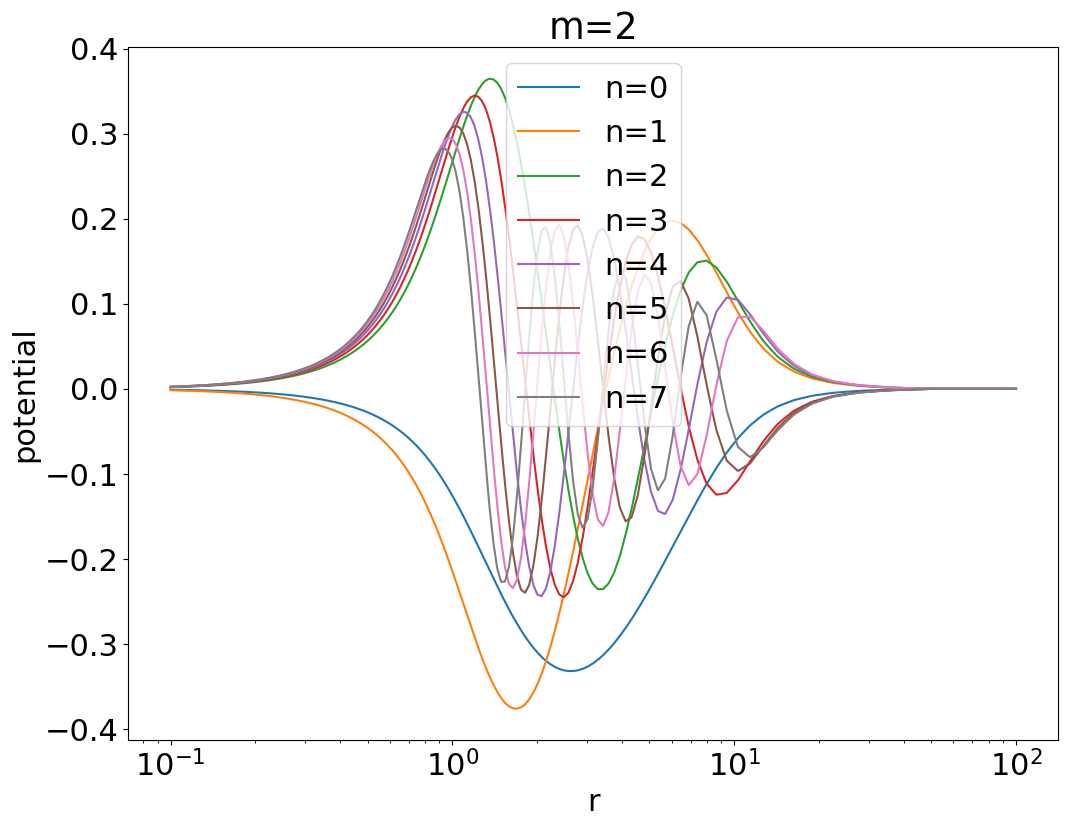

In [16]:
# Make a logarithmically space grid in radius
#
r = np.linspace(logxmin, logxmax, numgrid)
r = np.power(10.0, r)

for l in range(2,3):
    for n in range(8):
        plt.semilogx(r, disk_grid[l][n]['potential'], '-', label="n={}".format(n))
    plt.xlabel('r')
    plt.ylabel('potential')
    plt.title('m={}'.format(l))
    plt.legend()
    plt.show()
  